# **Capítulo 8: Visión por computador**

## Segmentación de animales en imágenes

Descargamos los datos del caso práctico

In [1]:
!wget -q http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget -q http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

Carga y preprocesado de datos

In [2]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision.transforms.functional import to_tensor

# Rutas a los directorios de imágenes y máscaras
imgs_dir = 'images'
mascs_dir = 'annotations/trimaps/'

# Tamaño de las imágenes y máscaras
tam_img = (160, 160)

# Número de imágenes a cargar
num_imgs = 3000

def cargar_datos(imgs_dir, mascs_dir, tam_img, num_imgs=None):
    X, Y = [], []

    img_list = sorted([i for i in os.listdir(imgs_dir)\
                       if i.endswith('.jpg') and not i.startswith('.')])
    if num_imgs is not None:
        img_list = img_list[:num_imgs]

    for inom in img_list:
        # Imagen
        img = Image.open(os.path.join(imgs_dir, inom)).convert('RGB')
        img = img.resize(tam_img)
        img = to_tensor(img)

        # Máscara
        mnom = inom.replace('.jpg', '.png')
        masc = Image.open(os.path.join(mascs_dir, mnom)).convert('L')
        masc = masc.resize(tam_img)
        masc = np.array(masc, dtype='uint8') - 1   # Clases: 1,2,3 -> 0,1,2
        masc = torch.from_numpy(masc)

        X.append(img)
        Y.append(masc)

    X = torch.stack(X)
    Y = torch.stack(Y).long() # Tipo 'long' para 'CrossEntropyLoss'

    return X, Y

X, Y = cargar_datos(imgs_dir, mascs_dir, tam_img, num_imgs)
print('¡Imágenes cargadas!')
print('Rango de valores de X: [{}, {}]'.format(X.min(), X.max()))

¡Imágenes cargadas!
Rango de valores de X: [0.0, 1.0]


Visualización del aspecto de los datos

Tamaño de las imágenes: torch.Size([3, 160, 160])
Tamaño de las máscaras: torch.Size([160, 160])


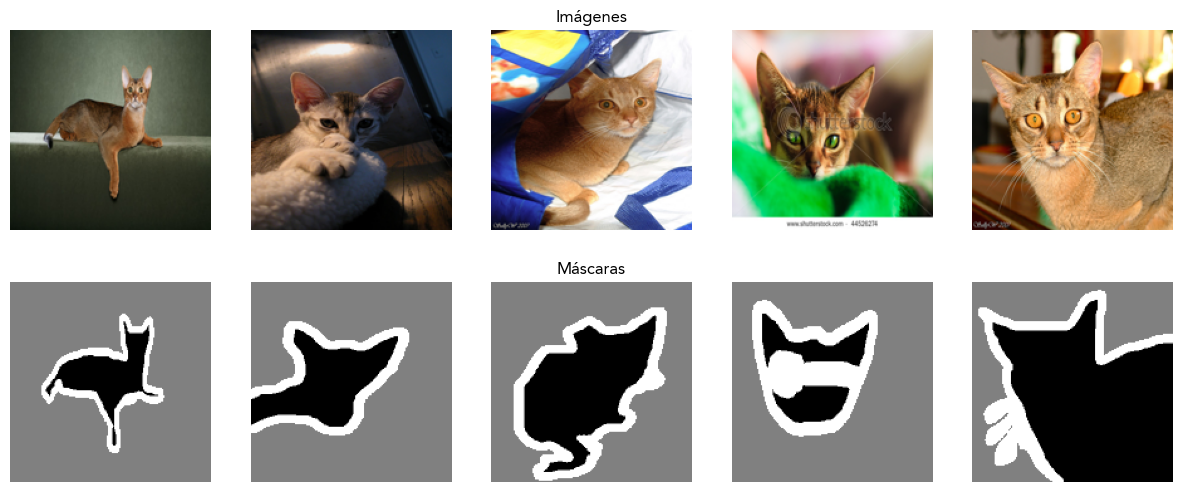

In [3]:
import matplotlib.pyplot as plt

# Tamaño de los datos
print(f'Tamaño de las imágenes: {X.shape[1:]}')
print(f'Tamaño de las máscaras: {Y.shape[1:]}')

# Visualizamos las imágenes y las máscaras
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(X[i].permute(1, 2, 0).numpy())
    axs[0, i].axis('off')
    axs[1, i].imshow(Y[i].numpy(), cmap='gray')
    axs[1, i].axis('off')
axs[0, 2].set_title('Imágenes')
axs[1, 2].set_title('Máscaras')
plt.show()

División del conjunto de datos en entrenamiento y test (80-20)

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,\
                                                    test_size=0.2,\
                                                    random_state=42)
print('¡Particiones realizadas!')
print(f'Tamaño del conjunto de entrenamiento: {X_train.shape[0]}')
print(f'Tamaño del conjunto de test: {X_test.shape[0]}')

# Creamos los data loaders
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

¡Particiones realizadas!
Tamaño del conjunto de entrenamiento: 2400
Tamaño del conjunto de test: 600


Implementación de la FCN a usar

In [4]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2

class FCN(nn.Module):
    def __init__(self, num_clases=3):
        super(FCN, self).__init__()

        # Codificador
        # Cargamos modelo preentrenado MobileNetV2
        # y nos quedamos con las capas deseadas
        # Tamaño salida: 32, 20, 20
        self.modelo_base = mobilenet_v2(weights='DEFAULT').features[:6]

        # Decodificador
        self.upsample1 = self.conv_transpose_bloque(32, 512)
        # 24 = canales de shortcut
        self.upsample2 = self.conv_transpose_bloque(512+24, 512)
        # 16 = canales de shortcut
        self.upsample3 = self.conv_transpose_bloque(512+16, 256)

        # Capa de salida
        self.salida = nn.Conv2d(256, num_clases, kernel_size=1,\
                                padding='same')

    def conv_transpose_bloque(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=3,\
                               stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_c),
            nn.Dropout(0.3)
        )

    def forward(self, x):
        residuales = []
        for i in range(len(self.modelo_base)):
            x = self.modelo_base[i](x)
            if i in [1, 3]:
                residuales.append(x)
        x = self.upsample1(x)
        x = self.upsample2(torch.cat([x, residuales[1]], 1))
        x = self.upsample3(torch.cat([x, residuales[0]], 1))
        x = self.salida(x)
        return x

modelo = FCN()

Implementación de la función de entrenamiento

In [5]:
def epoca_train(
        modelo, train_loader, optimizador, func_perdida, dispositivo):
    epoca_perdidas = []
    # Iteramos sobre los datos de entrenamiento
    for i, (imagenes, mascaras) in enumerate(train_loader):
        # Si es posible, transferimos los datos a la GPU
        imagenes = imagenes.to(dispositivo)
        mascaras = mascaras.to(dispositivo)
        # Ponemos los gradientes a cero
        optimizador.zero_grad()
        # Calculamos las salidas de la red neuronal
        # para las imágenes de entrada
        salidas = modelo(imagenes)
        # Calculamos la pérdida de la red neuronal
        perdida = func_perdida(salidas, mascaras)
        # Calculamos los gradientes de la pérdida
        # respecto a los parámetros de la red neuronal
        perdida.backward()
        # Actualizamos los parámetros de la red neuronal
        # usando el algoritmo de optimización
        optimizador.step()
        # Añadimos a la lista de pérdidas la pérdida actual
        epoca_perdidas.append(perdida.item())
    # Calculamos la media de las pérdidas para una época
    return sum(epoca_perdidas) / len(epoca_perdidas)

Implementación de la función de test

In [6]:
def epoca_test(modelo, test_loader, dispositivo):
    # Establecemos la red neuronal en modo de evaluación
    modelo.eval()
    # Desactivamos el cálculo de gradientes
    with torch.no_grad():
        correcto = 0
        total = 0
        # Iteramos sobre los datos de test
        for imagenes, mascaras in test_loader:
            # Si es posible, transferimos los datos a la GPU
            imagenes = imagenes.to(dispositivo)
            mascaras = mascaras.to(dispositivo)
            # Calculamos las salidas de la red neuronal
            # para las imágenes de entrada
            prediccion = modelo(imagenes)
            # Obtenemos la clase con mayor probabilidad para cada pixel
            prediccion = prediccion.softmax(dim=1)
            prediccion = prediccion.argmax(dim=1)
            # Incrementamos el contador de píxeles procesados
            total += mascaras.nelement()
            # Incrementamos el contador de píxeles
            # clasificados correctamente
            correcto += (prediccion == mascaras).sum().item()
        # Calculamos la exactitud
        exactitud = 100 * correcto / total
    # Establecemos la red neuronal en modo entrenamiento
    modelo.train()
    return exactitud

Implementación de la función de entrenamiento

In [7]:
def entrenar(modelo, train_loader, test_loader, epocas,\
             optimizador, func_perdida, dispositivo):
    # Históricos de valores de pérdida de entrenamiento
    train_perdidas = []
    # Históricos de valores de exactitud de entrenamiento,
    # y test
    train_accs, test_accs = [], []

    # Iteramos por cada época
    for epoca in range(epocas):
        # Entrenamos la red neuronal por una época
        train_perdida = epoca_train(modelo, train_loader, optimizador,\
                                    func_perdida, dispositivo)
        train_perdidas.append(train_perdida)
        # Calculamos la exactitud para los datos de entrenamiento
        train_acc = epoca_test(modelo, train_loader, dispositivo)
        train_accs.append(train_acc)
        # Calculamos la exactitud para los datos de test
        test_acc = epoca_test(modelo, test_loader, dispositivo)
        test_accs.append(test_acc)
        # Sacamos los resultados por pantalla
        print(f'Época {epoca+1}/{epocas},\
        pérdida={train_perdida:.4f},\
        exactitud_train={train_acc:.2f}%,\
        exactitud_test={test_acc:.2f}%')

    # Se ha completado el entrenamiento de la red neuronal
    print('Fin del entrenamiento.')
    return train_perdidas, train_accs, test_accs

Comprobación de acceso a GPU

In [8]:
dispositivo = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando {dispositivo}')

Usando cuda


Fine-tuning: primero, entrenamos solo las capas añadidas

In [9]:
import torch.optim as optim

# Modelo a GPU
modelo.to(dispositivo)

# Congelamos las capas del modelo base
for param in modelo.modelo_base.parameters():
    param.requires_grad = False

# Learning rate de 0.001 por defecto
optimizador = optim.Adam(modelo.parameters())
# Función de pérdida de entropía cruzada
func_perdida = nn.CrossEntropyLoss()

# Entrenamos el modelo
metricas1 = entrenar(modelo, train_loader, test_loader, 10,\
                     optimizador, func_perdida, dispositivo)

Época 1/10,        pérdida=0.7483,        exactitud_train=74.58%,        exactitud_test=75.15%
Época 2/10,        pérdida=0.6163,        exactitud_train=76.02%,        exactitud_test=76.42%
Época 3/10,        pérdida=0.5941,        exactitud_train=76.07%,        exactitud_test=76.43%
Época 4/10,        pérdida=0.5912,        exactitud_train=76.18%,        exactitud_test=76.63%
Época 5/10,        pérdida=0.5870,        exactitud_train=76.17%,        exactitud_test=76.56%
Época 6/10,        pérdida=0.5865,        exactitud_train=76.20%,        exactitud_test=76.60%
Época 7/10,        pérdida=0.5844,        exactitud_train=76.17%,        exactitud_test=76.59%
Época 8/10,        pérdida=0.5832,        exactitud_train=76.08%,        exactitud_test=76.40%
Época 9/10,        pérdida=0.5829,        exactitud_train=76.31%,        exactitud_test=76.70%
Época 10/10,        pérdida=0.5821,        exactitud_train=76.27%,        exactitud_test=76.62%
Fin del entrenamiento.


Fine-tuning: segundo, entrenamos el modelo al completo

In [10]:
# Descongelamos las capas del modelo base
for param in modelo.modelo_base.parameters():
    param.requires_grad = True

# Cambiamos el learning rate del optimizador
optimizador = optim.Adam(modelo.parameters(), lr=1e-5)

# Entrenamos el modelo
metricas2 = entrenar(modelo, train_loader, test_loader, 20,\
                     optimizador, func_perdida, dispositivo)

Época 1/20,        pérdida=0.5758,        exactitud_train=76.79%,        exactitud_test=77.17%
Época 2/20,        pérdida=0.5669,        exactitud_train=77.15%,        exactitud_test=77.56%
Época 3/20,        pérdida=0.5617,        exactitud_train=77.42%,        exactitud_test=77.85%
Época 4/20,        pérdida=0.5552,        exactitud_train=77.68%,        exactitud_test=78.10%
Época 5/20,        pérdida=0.5498,        exactitud_train=77.92%,        exactitud_test=78.34%
Época 6/20,        pérdida=0.5470,        exactitud_train=78.15%,        exactitud_test=78.57%
Época 7/20,        pérdida=0.5407,        exactitud_train=78.35%,        exactitud_test=78.79%
Época 8/20,        pérdida=0.5370,        exactitud_train=78.57%,        exactitud_test=79.01%
Época 9/20,        pérdida=0.5334,        exactitud_train=78.72%,        exactitud_test=79.18%
Época 10/20,        pérdida=0.5310,        exactitud_train=78.87%,        exactitud_test=79.33%
Época 11/20,        pérdida=0.5267,        exacti

Visualización de las curvas de aprendizaje

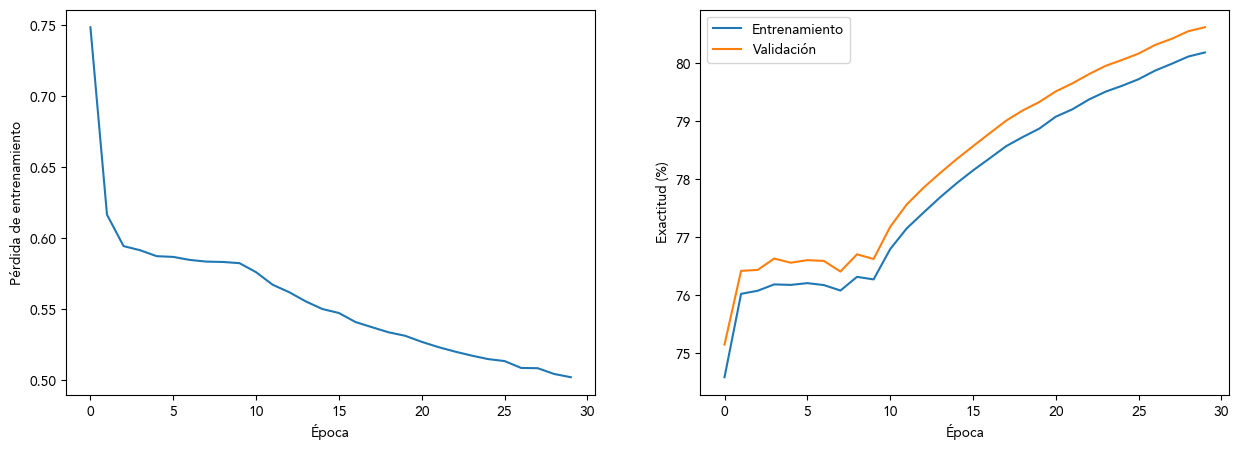

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Pérdida
axs[0].plot(metricas1[0]+metricas2[0])
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida de entrenamiento')
# Exactitud
axs[1].plot(metricas1[1]+metricas2[1], label='Entrenamiento')
axs[1].plot(metricas1[2]+metricas2[2], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud (%)')
axs[1].legend()
plt.show()

Visualización de las predicciones del modelo

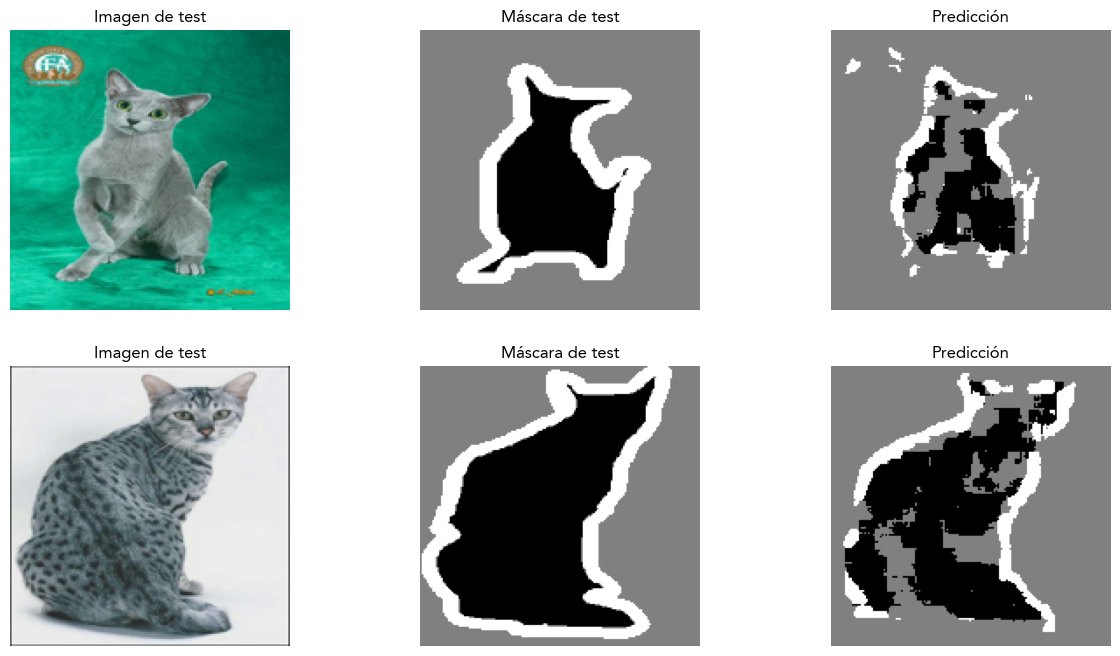

In [17]:
import matplotlib.pyplot as plt

# Obtenemos las predicciones para dos imágenes
modelo.eval()
with torch.no_grad():
    Y_pred = modelo(X_test[:2].to(dispositivo))
Y_pred = Y_pred.softmax(dim=1)
Y_pred = Y_pred.argmax(dim=1)

# Visualizamos las predicciones
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
for i in range(2):
    ax[i, 0].set_title('Imagen de test')
    ax[i, 0].imshow(X_test[i].permute(1, 2, 0).cpu().numpy())
    ax[i, 1].set_title('Máscara de test')
    ax[i, 1].imshow(Y_test[i].cpu().numpy(), cmap='gray')
    ax[i, 2].set_title('Predicción')
    ax[i, 2].imshow(Y_pred[i].cpu().numpy(), cmap='gray')
    # Hacemos los ejes invisibles
    for j in range(3):
        ax[i, j].set_axis_off()
plt.show()